#<div dir=rtl>
<h1> <b>توضیحات</b></h1>
</div>




<div dir=rtl>

ارزیابی دو زبانه (BLEU) یک معیار ارزیابی خودکار است که برای اندازه‌گیری شباهت فرضیه به مرجع استفاده می‌شود. BLEU هم کفایت را با نگاه کردن به دقت و هم روانی کلمه با محاسبه دقت n گرم برای n = 1، 2، 3، 4 اندازه گیری می کند. BLEU از طریق سه عامل محاسبه می شود:
1. دقت بر اساس n گرم خروجی ترجمه ماشینی و ترجمه مرجع،

2. جریمه  (BP)  

3. برش  کالیبراسیون



حالا بیایید کد را ببینیم.

ابتدا کلاس را تعریف کرده اید و n مقدار را برای n-gram:‌ مقداردهی اولیه کرده ایم
</div>



```
class bleu:
	def __init__(self, min_n_gram = 1, max_n_gram = 4):
		self.min_n_gram = min_n_gram
		self.max_n_gram = max_n_gram
```
<div dir=rtl>

تابع **bleu_score** را تعریف کرده که لیستی از جملات مرجع برای ورودی اول و جمله ای است که توسط ماشین برای ورودی دوم ترجمه شده است.


**n-gram** را برای مقادیر مختلف محاسبه میکنیم و عناصر را برای هر یک از **n** میشماریم.

**توجه:** این متریک قادر است جمله ترجمه شده ماشینی را با چندین جمله مرجع اندازه گیری کند زیرا ممکن است ترجمه های متفاوت اما درستی داشته باشد.
</div>

```
	def bleu_score(self, refs, pred):
		pred_ngram_count = [counter_element(ngrams(pred, n)) for n in range(self.min_n_gram, self.max_n_gram + 1)]
		pred_lenght = len(pred.split())

		refs_lenght = [len(ref.split()) for ref in refs]
		refs_ngram_count = list()
		for n in range(self.min_n_gram, self.max_n_gram + 1):
			result = [counter_element(ngrams(ref, n)) for ref in refs]
			refs_ngram_count.append(result)

```
<div dir=rtl>

برای اینکه از تکرار بیش از حد یک کلمه در ترجمه ماشینی جلوگیری کنیم.بین بیشترین تعداد تکرار یک عنصر  n-gram مشترک در جملات مرجع و جمله ترجمه شده توسط ماشینی کمترین را انتخاب میکنیم.

برای مثال :‌
</div>


refs = ["this is a blue ball"]

pred = ["ball ball ball ball]



<div dir=rtl>

به نظر ترجمه خوبی است زیرا تمام کلمات ترجمه ماشینی در مرجع موجود است



فرمول <b>cliped count</b>:

</div>




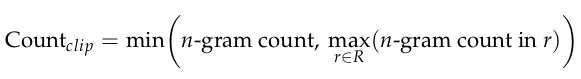

<div dir=rtl>

در اینجا می توانید پیاده سازی این فرمول را مشاهده کنید:‌

</div>

```
	def _clipped_count(self, refs_ngram, pred_ngram):
		score = 0
		for p_gram in pred_ngram:
			pred_ngram_count = pred_ngram[p_gram]
			max_gram_refs = 0
			for ref_ngram in refs_ngram:
				if p_gram in ref_ngram:
					max_gram_refs = max(max_gram_refs, ref_ngram[p_gram])

			score += min(max_gram_refs, pred_ngram_count)
		return score
```
<div dir=rtl>

حالا برای هر n محاسبه میکنیم :‌

</div>

```
		clipped_precision = list()
		for n in range(0, self.max_n_gram):
			clipped_count = self._clipped_count(refs_ngram_count[n], pred_ngram_count[n])
			clipped_precision.append(clipped_count / sum(pred_ngram_count[n].values()))
```
<div dir=rtl>

clipped_precision چیست ؟‌

</div>

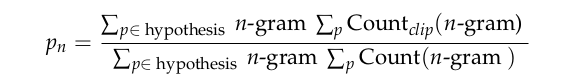

<div dir=rtl>

اگر داشته باشیم

</div>
 {

    ["this is a"] : 2,

    ["is a ball"] : 1,

    ["a ball is "] : 4,

}

count(n_gram) = 7


<div dir=rtl>

حالا زمان محاسبه امتیاز BLEU است:

</div>

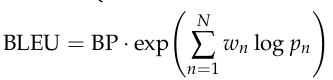

<div dir=rtl>
در فرمول فوق، $p_n$ و $w_n$ به ترتیب نشان دهنده دقت و وزن n ام گرم هستند.
امتیاز BLEU با جمع وزن و دقت و در نهایت ضرب در BP محاسبه می شود.

**w**ها همان اعداد ثابت هستند که هر کدام **0.25** است.

</div>

<div dir=rtl>

**BP** چیست؟

نرخ جریمه ای که ما برای این معیار در نظر گرفته ایم این است که فریب کوتاه بودن جمله ترجمه شده توسط ماشین الگوریتم را نخوریم.

مثلا :
</div>
pred = "this is"

ref = ["this is a blue ball and Beautiful"]
<div dir=rtl>

in clipped_precision , clipped count تقسیم بر مجموع عناصر در ریاضیات می دانیم که اگر مخرج کسر کوچک باشد عدد ما بزرگ است به همین دلیل میزان جریمه تعیین شده است.


فرمول محاسبه آن به شرح زیر است:
</div>

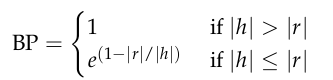


<div dir=rtl>

اکنون که تعداد جملات مرجع را داریم، باید آنها را با یک جمله مرجع مقایسه
کنیم که از نظر طول به یک جمله ترجمه شده ماشینی نزدیک است.

</div>

```
	def _get_closest_ref_lenght(self, refs_lenght, pred_lenght):
		return min(refs_lenght, key=lambda ref_lenght : abs(ref_lenght - pred_lenght))
```




```
	def _brevity_penalty(self, ref_lenght, pred_lenght):
		if pred_lenght > ref_lenght:
			return 1

		else:
			return math.exp(1 - ref_lenght / pred_lenght)
      
```



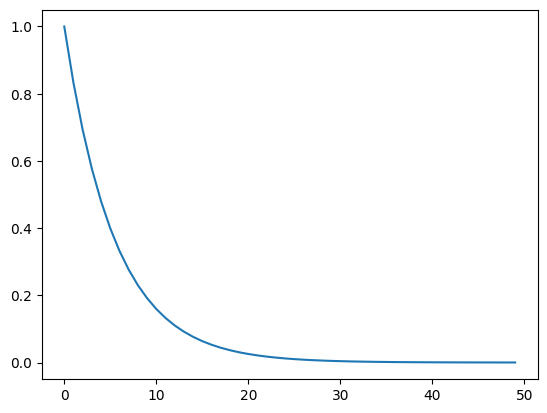

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

def func(temp):
  result = []
  for element in temp:
    num = math.exp(1 - element)
    if num not in result:
      result.append(num)
  return result

number = np.linspace(1, 10, 50, endpoint=True)


plt.plot(func(number))

<div dir=rtl>

و اکنون امتیاز bleu را طبق فرمول نهایی محاسبه کنید:

</div>

```
        db = 0
		for cp in clipped_precision:
			if cp == 0:
				db += math.log(1e-15) * (0.25)
			else :
				db += math.log(cp) * (0.25)

		return math.exp(db) * self._brevity_penalty(self._get_closest_ref_lenght(refs_lenght, pred_lenght), pred_lenght)
```
<div dir=rtl>
<b>  نکته</b>
اگر با عدد صفر برخورد کردیم از انجایی که لگاریتم عدد صفر تعریف نشده است پس لگاریتم عدد نزدیک به صفر را در نظر میگیریم

#<div dir=rtl>
<h1> <b>کد</b></h1>
</div>

##<div dir=rtl>
<h3> <b>ابزار ها</b></h3>
</div>

In [2]:
def counter_element(temp):
  counter = {}
  for element in temp:
    counter[element] = counter[element] + 1 if element in counter else 1
  return counter



def ngrams(text, n, ignore_split = False):
  if ignore_split:
    return [tuple(text[index : index + n]) for index in range(0, len(text) - n + 1)]
  else:

    text = text.lower()
    words = text.split()
    return [tuple(words[index : index + n]) for index in range(0, len(words) - n + 1)]

##<div dir=rtl>
<h3> <b>کد اصلی</b></h3>
</div>

In [3]:
class bleu:
	def __init__(self, min_n_gram = 1, max_n_gram = 4):
		self.min_n_gram = min_n_gram
		self.max_n_gram = max_n_gram

	def bleu_score(self, refs, pred):
		pred_ngram_count = [counter_element(ngrams(pred, n)) for n in range(self.min_n_gram, self.max_n_gram + 1)]
		pred_lenght = len(pred.split())

		refs_lenght = [len(ref.split()) for ref in refs]
		refs_ngram_count = list()
		for n in range(self.min_n_gram, self.max_n_gram + 1):
			result = [counter_element(ngrams(ref, n)) for ref in refs]
			refs_ngram_count.append(result)

		clipped_precision = list()
		for n in range(0, self.max_n_gram):
			clipped_count = self._clipped_count(refs_ngram_count[n], pred_ngram_count[n])
			clipped_precision.append(clipped_count / sum(pred_ngram_count[n].values()))


		db = 0
		for cp in clipped_precision:
			if cp == 0:
				db += math.log(1e-15) * (0.25)
			else :
				db += math.log(cp) * (0.25)

		return math.exp(db) * self._brevity_penalty(self._get_closest_ref_lenght(refs_lenght, pred_lenght), pred_lenght)


	def _clipped_count(self, refs_ngram, pred_ngram):
		score = 0
		for p_gram in pred_ngram:
			pred_ngram_count = pred_ngram[p_gram]
			max_gram_refs = 0
			for ref_ngram in refs_ngram:
				if p_gram in ref_ngram:
					max_gram_refs = max(max_gram_refs, ref_ngram[p_gram])

			score += min(max_gram_refs, pred_ngram_count)
		return score


	def _brevity_penalty(self, ref_lenght, pred_lenght):
		if pred_lenght > ref_lenght:
			return 1

		else:
			return math.exp(1 - ref_lenght / pred_lenght)

	def _get_closest_ref_lenght(self, refs_lenght, pred_lenght):
		return min(refs_lenght, key=lambda ref_lenght : abs(ref_lenght - pred_lenght))


##<div dir=rtl>
<h3> <b>تست کد با مثال</b></h3>
</div>

In [4]:
model = bleu()

##<div dir=rtl>
<h4> <b>جملات یکسان</b></h4>
</div>

In [5]:
ref = "this is a blue ball and it is beatiful"
pred = "this is a blue ball and it is beatiful"
model.bleu_score([ref], pred)

1.0

##<div dir=rtl>
<h4> <b>جملات کاملا متفاوت </b></h4>
</div>

In [7]:
ref = "this is a blue ball and it is beatiful"
pred = "i love java nad python "
score = model.bleu_score([ref], pred)
round(score, 2)

0.0

##<div dir=rtl>
<h4> <b>جملات  با عناصر تکراری </b></h4>
</div>

In [9]:
ref = "this is a blue ball and it is beatiful"
pred = "this  this this this is a blue ball and it is beatiful"
model.bleu_score([ref], pred)


0.7102992180127422

In [13]:
ref = "this is a blue ball and it is beatiful"
pred = "this is a bluee ball and it is beatiful"
model.bleu_score([ref], pred)

0.5969491792019646

<div dir=rtl>

یکی از نقاط ضعف آن این است که در جملات کوتاه با تغییر یک کلمه امتیز به صورت ناگهانی افت میکند زیرا در جملات کوتاه دسته های n-gram محدود به عناصر کمتری شده

برای مثال :‌

</div>

"this is a ball"

4 - gram = [this is a ball]
<div dir=rtl>

تنها شامل یک عنصر است
</div>


#<div dir=rtl>
<h1> <b>نتیجه گیری</b></h1>
</div>

<div dir=rtl>

عدد خروجی این متریک بین صفر و یک است

* یک به معنای تطابق صد در صدی با جمله های مرجع

* صفر به معنای عدم تطابق صد در صدی با جمله  های مرجع

</div>

<div dir=rtl>
<h1> <b>منابع</b></h1>
</div>

* [ref - 1](https://dl.acm.org/doi/pdf/10.5555/1289189.1289273)

* [ref - 2](https://www.mdpi.com/2227-7390/11/4/1006)

* [ref - 3](https://www.aclweb.org/anthology/P02-1040.pdf)